## 다람쥐, 쥐, 토끼의 COI 염기서열 140개 무작위 추출 후 aln으로 저장

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   

## 원본과 예측값 비교를 위한 시각화 

In [4]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
species = ['Rattus rattus', 'Mus musculus', 'Microtus fortis', 'Tamias sibiricus', 'Pteromys volans',
            'Sciurus vulgaris', 'Cricetulus barabensis', 'Myodes rutilus', 'Apodemus agrarius']

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    for id in Idlist:
        getFasta(id)

## creating MT932266.1.fasta...
## creating NC_012374.1.fasta...
## creating MN536017.1.fasta...


KeyboardInterrupt: 

In [3]:
getAln('all_coi.fasta')

/Users/kimjoonsu/muscle3.8.31_i86darwin64 -in all_coi.fasta -out all_coi.aln -clw


## 데이터 전처리 및 DataFrame 구성

* DataFrame의 Target 구성을 위해 종(species) 크롤링 

In [2]:
from Bio import SeqIO
from Bio import Entrez
from Bio import GenBank

Entrez.email = "nagabuti13@naver.com"

#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getOrganism(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    a = []
    for i in r.organism:
        if(i.isdigit() == True):
            break
        else:
            a.append(i)
    return ''.join(a[:-1])


* DataFrame의 열(feature) 구성을 위해 k-mer(k = 3)을 활용

In [3]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('dna_file/all_coi.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getOrganism(record.id)
    index = 0
    if(len(record.seq) >= k):
        while(index + k <= 1546):
            mer = record.seq[index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [4]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,Cricetulus barabensi
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,Cricetulus barabensi
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,Cricetulus barabensi
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,Myodes rutilu
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,Microtus forti
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,Pteromys volan
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,Pteromys volan
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,Pteromys volan
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,Pteromys volan



* 머신러닝 적용을 위해 DataFrame의 Target의 종 이름(문자열) -> 고유 숫자(숫자) cf)One-Hot Encoding과 비슷한 방식

## 머신러닝으로 9개 종 군집화

### SVM

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel = 'linear', C = 4, gamma = 5)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
get_clf_eval(y_test, svm_pred)

오차 행렬
[[4 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 5]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


In [7]:
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 3)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

""" scores_df = pd.DataFrame(grid_svm.cv_results_)
scores_df = scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]
scores_df[scores_df['rank_test_score'] == 1] """

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

{'C': 1, 'gamma': 1}
0.9912280701754387
오차 행렬
[[3 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 4 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 9]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


In [21]:
best_pred

array(['Sciurus vulgari', 'Tamias sibiricu', 'Microtus forti',
       'Apodemus agrariu', 'Tamias sibiricu', 'Myodes rutilu',
       'Sciurus vulgari', 'Rattus rattu', 'Pteromys volan',
       'Tamias sibiricu', 'Microtus forti', 'Myodes rutilu',
       'Rattus rattu', 'Mus musculu', 'Myodes rutilu', 'Myodes rutilu',
       'Tamias sibiricu', 'Myodes rutilu', 'Apodemus agrariu',
       'Myodes rutilu', 'Rattus rattu', 'Sciurus vulgari',
       'Tamias sibiricu', 'Microtus forti', 'Rattus rattu',
       'Tamias sibiricu', 'Tamias sibiricu', 'Tamias sibiricu',
       'Apodemus agrariu'], dtype=object)

* PCA(차원 축소)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.iloc[:, :-1])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,---,target,pca_x,pca_y
0,7,2,12,21,6,8,15,7,13,2,...,8,16,22,11,13,20,907,Cricetulus barabensi,-76.247468,-5.251898
1,7,0,13,21,6,9,14,6,12,4,...,13,18,23,8,19,16,891,Cricetulus barabensi,-60.139911,-5.960608
2,7,0,13,20,6,10,14,6,12,4,...,13,17,23,8,18,16,891,Cricetulus barabensi,-60.034678,-5.965458
3,6,2,18,16,4,11,15,6,15,5,...,17,16,15,7,18,9,891,Myodes rutilu,-60.236973,6.342047
4,5,2,17,18,4,9,14,8,13,4,...,15,15,12,5,19,10,880,Microtus forti,-48.955385,8.967086


In [23]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[1 1 1 4 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5 5 5 5 5]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,---,target,pca_x,pca_y
0,7,2,12,21,6,8,15,7,13,2,...,8,16,22,11,13,20,907,1,-76.247468,-5.251898
1,7,0,13,21,6,9,14,6,12,4,...,13,18,23,8,19,16,891,1,-60.139911,-5.960608
2,7,0,13,20,6,10,14,6,12,4,...,13,17,23,8,18,16,891,1,-60.034678,-5.965458
3,6,2,18,16,4,11,15,6,15,5,...,17,16,15,7,18,9,891,4,-60.236973,6.342047
4,5,2,17,18,4,9,14,8,13,4,...,15,15,12,5,19,10,880,2,-48.955385,8.967086


* <원본>

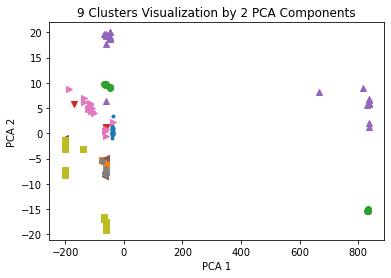

In [24]:
marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

* <예측값>

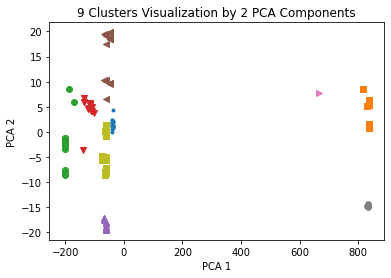

In [11]:
marker_ind = []
for i in range(9):
    marker_ind.append(df[df['kmeans_cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

In [12]:
df.iloc[:,:-4]

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,---
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,907
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,891
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,891
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,891
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,1032
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,1032
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,1032
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,1032
